# Use OSMnx to get street networks by place name

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  
Once you've perused the features demo and overview notebooks, this notebook provides further demonstration of querying by place name with OSMnx.

In [1]:
import osmnx as ox

%matplotlib inline
ox.__version__

'1.7.0'

OSMnx lets you download street network data and build topologically corrected multidigraphs, project to UTM and plot the networks, and save the street network as SVGs, GraphML files, or GeoPackages for later use. The street networks are directed and preserve one-way directionality. API responses can be cached locally so OSMnx doesn't have to request the same data from the API multiple times: saving bandwidth, increasing speed, and enabling reproducibility.

You can download a street network by providing OSMnx any of the following:
  - a bounding box
  - a lat-long point plus a distance (either distance along the network, or cardinal)
  - an address plus a distance (either distance along the network, or cardinal)
  - a place name or list of place names (for OSMnx to automatically geocode and get the boundary of)
  - a polygon of the desired street network's boundaries

You can also specify several different built-in network types:
  - `drive` - get drivable public streets (but not service roads)
  - `drive_service` - get drivable streets, including service roads
  - `walk` - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
  - `bike` - get all streets and paths that cyclists can use
  - `all` - download all non-private OSM streets and paths
  - `all_private` - download all OSM streets and paths, including private-access ones

Or you can define your own fine-tuned network type using OSMnx's `custom_filter` parameter (to get just highways, or railways, canals, etc).

## 1. Query/download place boundaries

The `graph_from_place` function uses place boundary geocoding logic to find the network within your place's boundary. Let's look briefly at this place boundary querying before we get to street networks. You can download by cities, neighborhoods, boroughs, counties, states, or countries: anything with geocodable polygon boundaries in OSM's database. Notice the polygon geometries represent political boundaries, not physical/land boundaries. OSMnx will turn your geocoded place (or multiple places) boundaries into a geopandas GeoDataFrame.

In [2]:
# neighborhoods or boroughs
gdf = ox.geocode_to_gdf("Manhattan, New York, New York, USA")

# counties
gdf = ox.geocode_to_gdf("Cook County, Illinois, United States")

# states
gdf = ox.geocode_to_gdf("Iowa")

In [3]:
# you can get multiple countries in a single query
gdf = ox.geocode_to_gdf(["United Kingdom", "Ireland"])

# or multiple cities
places = [
    "Berkeley, California, USA",
    "Oakland, California, USA",
    "Piedmont, California, USA",
    "Emeryville, California, USA",
    "Alameda, Alameda County, CA, USA",
]
gdf = ox.geocode_to_gdf(places)

The `geocode_to_gdf` function takes a `which_result` argument. Its default value `None` makes OSMnx retrieve the first result with geometry type Polygon/MultiPolygon (if one exists on OSM). Alternatively, pass an integer value as `which_result` to retrieve a specific geocoding result, regardless of its geometry type.

When querying, be specific and explicit, and sanity check the results. Try passing a dict instead of a string to be more explicit.

In [4]:
# oops, this gets the county of alameda rather than the city!
alameda1 = ox.geocode_to_gdf("Alameda, California, USA")

# this gets the city of alameda
alameda2 = ox.geocode_to_gdf(
    {
        "city": "Alameda",
        "county": "Alameda County",
        "state": "California",
        "country": "USA",
    }
)

# the city is a very small part of the county
alameda1 = ox.project_gdf(alameda1)
alameda2 = ox.project_gdf(alameda2)
alameda2.area.iloc[0] / alameda1.area.iloc[0]

0.02792130196492575

OSM resolves 'Mexico' to Mexico City (as the first geocoding result) and returns a single point at the center of the city. If we want the boundaries of the country of Mexico, we can 1) specify which_result=None to find the first polygon and hope it's the country, or 2) pass a dict containing a structured query to specify that we want Mexico the country instead of Mexico the city.

In [5]:
mexico = ox.geocode_to_gdf("Mexico", which_result=2)
type(mexico["geometry"].iloc[0])

shapely.geometry.polygon.Polygon

In [6]:
# let the geocoder find the first Polygon/MultiPolygon result
mexico = ox.geocode_to_gdf("Mexico", which_result=None)
type(mexico["geometry"].iloc[0])

shapely.geometry.multipolygon.MultiPolygon

In [7]:
# instead of a string, you can pass a dict containing a structured query for better precision
mexico = ox.geocode_to_gdf({"country": "Mexico"})
type(mexico["geometry"].iloc[0])

shapely.geometry.multipolygon.MultiPolygon

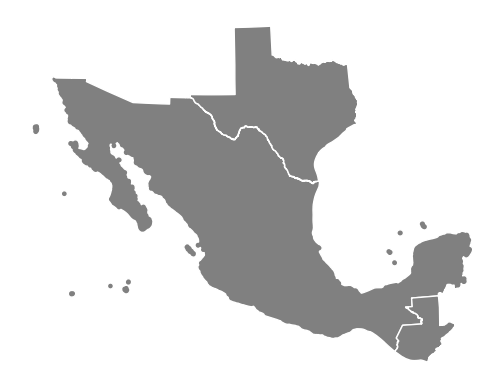

In [8]:
# you can pass multiple queries with mixed types (dicts and strings)
mx_gt_tx = ox.geocode_to_gdf([{"country": "Mexico"}, "Guatemala", {"state": "Texas"}])
mx_gt_tx = ox.project_gdf(mx_gt_tx)
ax = mx_gt_tx.plot(fc="gray", ec="w")
_ = ax.axis("off")

If you query 'France', OSM returns the country with all its overseas territories as result 1 and Metropolitan France alone as later down the results. Passing `which_result` can help you specifically retrieve the desired geocoding result, or you can query the geospatial feature you want by its OSM ID.

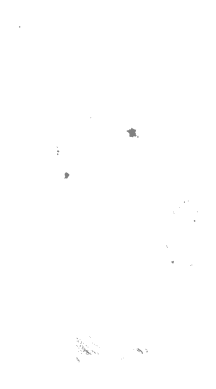

In [9]:
france = ox.geocode_to_gdf("France")
france = ox.project_gdf(france)
ax = france.plot(fc="gray", ec="none")
_ = ax.axis("off")

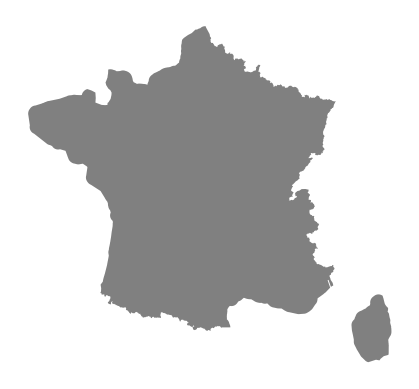

In [10]:
france = ox.project_gdf(ox.geocode_to_gdf("R1403916", by_osmid=True))
ax = france.plot(fc="gray", ec="none")
_ = ax.axis("off")

Finally, note that you can also query by OSM ID rather than place name by passing `by_osmid=True` to the function. See documentation for usage details.

## 2. Get street networks by place name

This "by place" querying logic works the same as the place boundary querying we just saw above.

In [11]:
# get the walking network for piedmont
G = ox.graph_from_place("Piedmont, California, USA", network_type="walk")

In [12]:
# or get the walking network within a 500 meter buffer of piedmont
polygon = ox.geocode_to_gdf("Piedmont, California, USA").loc[0, "geometry"]
poly_proj, crs_proj = ox.projection.project_geometry(polygon)
polygon, _ = ox.projection.project_geometry(poly_proj.buffer(500), crs=crs_proj, to_latlong=True)
G = ox.graph_from_polygon(polygon, network_type="walk")

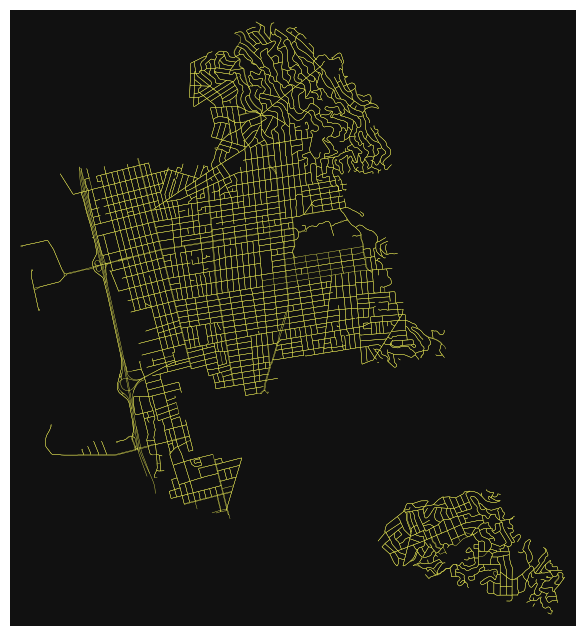

In [13]:
# create a network from multiple places
places = [
    "Piedmont, California, USA",
    {"city": "Berkeley", "state": "California"},
    "Emeryville, California, USA",
]

# use retain_all to keep all disconnected subgraphs (e.g. if your places aren't contiguous)
G = ox.graph_from_place(places, network_type="drive", retain_all=True)
fig, ax = ox.plot_graph(G, node_size=0, edge_color="#FFFF5C", edge_linewidth=0.25)

In [14]:
# or create a network from structured place queries
places = [
    {"city": "Daly City", "state": "California"},
    {"city": "South San Francisco", "state": "California"},
]
G = ox.graph_from_place(places, network_type="drive")

In [15]:
# get the network for the borough of manhattan
G = ox.graph_from_place("Manhattan, New York, New York, USA", network_type="drive")

In [16]:
# get the network for a neighborhood
place = "SoHo, New York, NY"
G = ox.graph_from_place(place, network_type="drive")

In [17]:
%%time
# get the network for all of LA
# takes a couple minutes to do all the downloading and processing
place = "Los Angeles, California, USA"
G = ox.graph_from_place(place, network_type="drive", simplify=False, retain_all=True)

CPU times: total: 41.8 s
Wall time: 57.8 s


In [18]:
# create a network constrained to the shape of hong kong island
G = ox.graph_from_place("Hong Kong Island", network_type="drive")